In [1]:
import tensorflow as tf
import time

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.7)

In [2]:
import tarfile
import re
import urllib.request
import os
import random

class ImdbMovieReviews:
    DEFAULT_URL = \
        'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
    TOKEN_REGEX = re.compile(r'[A-Za-z]+|[!?.:,()]')
    
    def __init__(self):
        self._cache_dir = './imdb'
        self._url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
        
        if not os.path.isfile(self._cache_dir):
            urllib.request.urlretrieve(self._url, self._cache_dir)
        self.filepath = self._cache_dir

    def __iter__(self):
        with tarfile.open(self.filepath) as archive:
            items = archive.getnames()
            for filename in archive.getnames():
                if filename.startswith('aclImdb/train/pos/'):
                    yield self._read(archive, filename), True
                elif filename.startswith('aclImdb/train/neg/'):
                    yield self._read(archive, filename), False
                    
    def _read(self, archive, filename):
        with archive.extractfile(filename) as file_:
            data = file_.read().decode('utf-8')
            data = type(self).TOKEN_REGEX.findall(data)
            data = [x.lower() for x in data]
            return data

In [3]:
import numpy as np
# Spacy is my favourite nlp framework, which havu builtin word embeddings trains on wikipesia
# from spacy.en import English
import spacy

class Embedding:
    
    def __init__(self):
#          spaCy makes using word vectors very easy. 
#             The Lexeme , Token , Span  and Doc  classes all have a .vector property,
#             which is a 1-dimensional numpy array of 32-bit floats:
#         self.parser = English()
        self.parser = spacy.load('en')
#         self.parser = spacy.load('en_vectors_web_lg')
#         self._length = length
        self.dimensions = 300
        
    def __call__(self, sequence, length):
        # DO I really need them to be equal length?
        # Let's assume I'm not
        data = np.zeros((length, self.dimensions))
        # you can access known words from the parser's vocabulary
        embedded = [self.parser.vocab[w].vector for w in sequence]
        data[:len(sequence)] = embedded
        return data

In [4]:
import itertools

def preprocess_batched_split(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch = []
        labelss = []
        sentence_sizes_batch = []
        for index in range(batch_size):
            text, label = next(iterator)
            sents = [list(y) for x, y in itertools.groupby(text, lambda z: z == '.') if not x]
            sentence_sizes = [len(s) for s in sents]
            text_embed = [embedding(sent) for sent in sents]
            
            batch.append(text_embed)
            labelss.append(label)
            sentence_sizes_batch.append(sentence_sizes)
            
        labels_batch = np.array(labelss, dtype=np.int32)
        sent_per_doc = np.array([len(x) for x in sentence_sizes_batch])
        words_per_sent_per_doc = np.array(sentence_sizes_batch)
        yield np.array(batch), labels_batch, words_per_sent_per_doc, sent_per_doc

In [5]:
import itertools

def preprocess_batched_split2(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch, labels_b = zip(*itertools.islice(iterator, batch_size))
        
        sents_b = [[list(y) for x, y in itertools.groupby(doc, lambda z: z == '.') if not x] for doc in batch]

        sentence_sizes_b = [[len(sent) for sent in doc] for doc in sents_b]
        sentence_size = max(map(max, sentence_sizes_b))
        
        document_sizes = np.array([len(doc) for doc in sentence_sizes_b], dtype=np.int32)
        document_size = document_sizes.max()

        sentence_sizes_np = np.zeros(shape=[batch_size, document_size], dtype=np.int32)
        for bi, ds, ss in zip(range(sentence_sizes_np.shape[0]), document_sizes, sentence_sizes_b):
            sentence_sizes_np[bi][:ds] = ss
        
        text_embed_b = np.zeros((batch_size, document_size, sentence_size, 300))
        for i, ds, doc_sents in zip(range(text_embed_b.shape[0]), document_sizes, sents_b):
            doc_sents_embed = np.array([embedding(sent, sentence_size) for sent in doc_sents])
            text_embed_b[i][:ds] = doc_sents_embed
        
        yield text_embed_b, np.array(labels_b, dtype=np.int32), np.array(document_sizes), sentence_sizes_np, sents_b

In [6]:
reviews = list(ImdbMovieReviews())

In [7]:
random.shuffle(reviews)

In [8]:
#################################################

In [8]:
# import sys
# sys.path.insert(0, '/home/emaljutina/au_dl_course/seminar_9/homework/')

In [10]:
# sys.path

['/home/emaljutina/au_dl_course/seminar_9/homework/',
 '',
 '/opt/anaconda3/lib/python36.zip',
 '/opt/anaconda3/lib/python3.6',
 '/opt/anaconda3/lib/python3.6/lib-dynload',
 '/opt/anaconda3/lib/python3.6/site-packages',
 '/opt/anaconda3/lib/python3.6/site-packages/Sphinx-1.5.6-py3.6.egg',
 '/opt/anaconda3/lib/python3.6/site-packages/setuptools-27.2.0-py3.6.egg',
 '/opt/anaconda3/lib/python3.6/site-packages/IPython/extensions',
 '/home/emaljutina/.ipython']

In [8]:
%reload_ext autoreload
%autoreload 1
%aimport HanSequenceLabellingModel
%aimport model_components
%aimport

Modules to reload:
HanSequenceLabellingModel model_components

Modules to skip:



In [9]:
batches_split = preprocess_batched_split2(reviews, Embedding(), batch_size=10)

In [10]:
from HanSequenceLabellingModel import HanSequenceLabellingModel

In [11]:
def HAN_model_1(session, restore_only=False):
    """Hierarhical Attention Network"""
    import tensorflow as tf
    try:
        from tensorflow.contrib.rnn import GRUCell, MultiRNNCell, DropoutWrapper
    except ImportError:
        MultiRNNCell = tf.nn.rnn_cell.MultiRNNCell
        GRUCell = tf.nn.rnn_cell.GRUCell
    from bn_lstm import BNLSTMCell
    from HanSequenceLabellingModel import HanSequenceLabellingModel

    is_training = tf.placeholder(dtype=tf.bool, name='is_training')

    cell = BNLSTMCell(80, is_training) # h-h batchnorm LSTMCell
    cell = MultiRNNCell([cell]*5)

    model = HanSequenceLabellingModel(
            embedding_size=300,
            classes=2,
            word_cell=cell,
            sentence_cell=cell,
            word_output_size=300,
            sentence_output_size=300,
            learning_rate=0.001,
            max_grad_norm=5.0,
            dropout_keep_proba=0.5,
            is_training=is_training,
    )

    saver = tf.train.Saver(tf.global_variables())
    checkpoint_dir = 'checkpoints'
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    if checkpoint:
        print("Reading model parameters from %s" % checkpoint.model_checkpoint_path)
        saver.restore(session, checkpoint.model_checkpoint_path)
    elif restore_only:
        raise FileNotFoundError("Cannot restore model")
    else:
        print("Created model with fresh parameters")
        session.run(tf.global_variables_initializer())
        
    return model, saver

In [36]:
max_iters = 500

In [38]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    tflog_dir = 'tf_logs'
    summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())

    for data, labels_batch, sent_per_doc, words_per_sent_per_doc, _ in batches_split:

        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        t0 = time.clock()
        step, summaries, loss, accuracy, _ = s.run([
                model.global_step,
                model.summary,
                model.loss,
                model.accuracy,
                model.train_op,
        ], feed_dict=fd)
        td = time.clock() - t0

        summary_writer.add_summary(summaries, global_step=step)

        checkpoint_frequency = 30
        eval_frequency = 1
        
        if step >= max_iters:
            break
        
        if step % 1 == 0:
            print('step %s, loss=%s, accuracy=%s, t=%s, inputs=%s' % (step, loss, accuracy, round(td, 2), fd[model.inputs_embedded].shape))
        if step != 0 and step % checkpoint_frequency == 0:
#             print('checkpoint & graph meta')
            checkpoint_path = 'checkpoints/checkpoint'
            saver.save(s, checkpoint_path, global_step=step)
#             print('checkpoint done')

Reading model parameters from checkpoints/checkpoint-120
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-120
step 121, loss=0.751553, accuracy=0.4, t=21.05, inputs=(10, 13, 198, 300)
step 122, loss=0.778923, accuracy=0.7, t=12.76, inputs=(10, 25, 118, 300)
step 123, loss=0.692129, accuracy=0.5, t=8.29, inputs=(10, 18, 77, 300)
step 124, loss=0.616933, accuracy=0.9, t=11.62, inputs=(10, 37, 91, 300)
step 125, loss=0.971886, accuracy=0.4, t=8.4, inputs=(10, 28, 68, 300)
step 126, loss=0.664534, accuracy=0.7, t=12.11, inputs=(10, 40, 96, 300)
step 127, loss=0.673485, accuracy=0.6, t=10.5, inputs=(10, 27, 93, 300)
step 128, loss=0.551665, accuracy=0.7, t=12.43, inputs=(10, 35, 104, 300)
step 129, loss=0.553261, accuracy=0.9, t=9.49, inputs=(10, 28, 78, 300)
step 130, loss=0.659165, accuracy=0.5, t=6.9, inputs=(10, 20, 59, 300)
step 131, loss=0.542788, accuracy=0.9, t=8.84, inputs=(10, 17, 85, 300)
step 132, loss=0.53501, accuracy=0.6, t=8.7, inputs=(10, 17, 86, 300)
step 1

step 233, loss=0.671095, accuracy=0.8, t=7.36, inputs=(10, 27, 56, 300)
step 234, loss=0.393245, accuracy=0.8, t=11.56, inputs=(10, 19, 113, 300)
step 235, loss=0.327059, accuracy=0.8, t=10.63, inputs=(10, 33, 87, 300)
step 236, loss=0.342848, accuracy=0.9, t=10.36, inputs=(10, 25, 92, 300)
step 237, loss=0.925362, accuracy=0.6, t=9.11, inputs=(10, 16, 90, 300)
step 238, loss=0.311881, accuracy=0.9, t=6.95, inputs=(10, 21, 58, 300)
step 239, loss=0.234265, accuracy=0.9, t=17.21, inputs=(10, 17, 176, 300)
step 240, loss=0.305449, accuracy=0.9, t=11.96, inputs=(10, 43, 87, 300)
step 241, loss=0.753397, accuracy=0.5, t=12.64, inputs=(10, 26, 114, 300)
step 242, loss=0.262574, accuracy=1.0, t=7.15, inputs=(10, 29, 50, 300)
step 243, loss=0.433611, accuracy=0.7, t=9.52, inputs=(10, 26, 83, 300)


KeyboardInterrupt: 

In [54]:
# print('RGB color cube, 6x6x6:')
# for green in range(6):
#     for red in range(6):
#         for blue in range(6):
#             print_color('{}{}{}'.format(red, green, blue), bg=rgb(red, green, blue), end='')
#         print(' ', end='')
#     print()
# print()

RGB color cube, 6x6x6:
000001002003004005 100101102103104105 200201202203204205 300301302303304305 400401402403404405 500501502503504505 
010011012013014015 110111112113114115 210211212213214215 310311312313314315 410411412413414415 510511512513514515 
020021022023024025 120121122123124125 220221222223224225 320321322323324325 420421422423424425 520521522523524525 
030031032033034035 130131132133134135 230231232233234235 330331332333334335 430431432433434435 530531532533534535 
040041042043044045 140141142143144145 240241242243244245 340341342343344345 440441442443444445 540541542543544545 
050051052053054055 150151152153154155 250251252253254255 350351352353354355 450451452453454455 550551552553554555 



In [14]:
(
    BLACK,
    RED,
    GREEN,
    YELLOW,
    BLUE,
    MAGENTA,
    CYAN,
    LIGHT_GRAY,
    DARK_GRAY,
    BRIGHT_RED,
    BRIGHT_GREEN,
    BRIGHT_YELLOW,
    BRIGHT_BLUE,
    BRIGHT_MAGENTA,
    BRIGHT_CYAN,
    WHITE,
) = range(16)

def rgb(red, green, blue):
    """
    Calculate the palette index of a color in the 6x6x6 color cube.
    The red, green and blue arguments may range from 0 to 5.
    """
    return 16 + (red * 36) + (green * 6) + blue

def gray(value):
    """
    Calculate the palette index of a color in the grayscale ramp.
    The value argument may range from 0 to 23.
    """
    return 232 + value

def set_color(fg=None, bg=None):
    """
    Print escape codes to set the terminal color.
    fg and bg are indices into the color palette for the foreground and
    background colors.
    """
    print(_set_color(fg, bg), end='')

def _set_color(fg=None, bg=None):
    result = ''
    if fg:
        result += '\x1b[38;5;%dm' % fg
    if bg:
        result += '\x1b[48;5;%dm' % bg
    return result

def reset_color():
    """
    Reset terminal color to default.
    """
    print(_reset_color(), end='')

def _reset_color():
    return '\x1b[0m'

def print_color(*args, **kwargs):
    """
    Print function, with extra arguments fg and bg to set colors.
    """
    fg = kwargs.pop('fg', None)
    bg = kwargs.pop('bg', None)
    set_color(fg, bg)
    print(*args, **kwargs)
    reset_color()

In [84]:
 print_color('test', bg=rgb(5, 5, 3), end=' ')

test 

In [39]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    tflog_dir = 'tf_logs'
    summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())
    
    data, labels_batch, sent_per_doc,\
    words_per_sent_per_doc, sents_batch = next(batches_split)

    fd = {
        model.is_training: True,
        model.inputs_embedded: data,
        model.word_lengths: words_per_sent_per_doc,
        model.sentence_lengths: sent_per_doc,
        model.labels: labels_batch,
        model.sample_weights: np.ones(shape=(10))
    }

    word_attentions, sent_attentions = s.run([model.word_attentions, 
                                              model.sent_attentions], 
                                             feed_dict=fd)
    
    sent_atts = sent_attentions[0]
    sents = sents_batch[0]
    
    max_sent_att = 0
    max_word_att = 0
    
    for sent_index in range(len(sents)):
        max_sent_att = max(max_sent_att, sent_atts[sent_index])
        
        for word_index in range(len(sents[sent_index])):
            max_word_att = max(max_word_att, word_attentions[sent_index][word_index])
    
    def draw_highlighted_att(max_sent_att_loc, max_word_att_loc):
        for sent_index in range(len(sents)):
            for word_index in range(len(sents[sent_index])):
                intsty = 2 - int(word_attentions[sent_index][word_index] / max_word_att_loc * 5)
                print_color(sents[sent_index][word_index], bg=rgb(2, 5, intsty), end=' ') 
            print()
    
    draw_highlighted_att(max_sent_att, max_word_att)
    print()
    draw_highlighted_att(1.0, 1.0)

Reading model parameters from checkpoints/checkpoint-240
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-240
this movie is similar to the play entitled blithe spirit written by noel coward 
the plot of a ghost wife and a medium are strongly linked to coward s writing 
i m surprised that movies of this nature don t acknowledge the original writer s concept 
i realize that the public may not be aware that this is a knockoff but it is 
br br sad 
these movies are so expensive to produce 
i do perk up when a screenplay is original 
i even perk up when it s an innovative way to produce a work that was previously released 
there were some samples mentioned ( such as topper , etc 
) 
br br i realize that movies are still a comparatively affordable form of entertainment 
however , i m not please when the public s taste is taken for granted 
in this situation , the public s taste is overlooked 
br br i look forward to better produced movie entertainment 
br br in this case 
i r

In [18]:
import tqdm

In [40]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_options)

good_true = list()
good_false = list()
bad_false = list()
bad_true = list()

with tf.device('/cpu:0'):
    with tf.Session(config=config) as sess:
        model, saver = HAN_model_1(sess, True)

        
        for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_b) in  tqdm.tqdm_notebook(enumerate(batches_split), total=max_iters):
            fd = {
                model.is_training: True,
                model.inputs_embedded: data,
                model.word_lengths: words_per_sent_per_doc,
                model.sentence_lengths: sent_per_doc,
                model.labels: labels_batch,
                model.sample_weights: np.ones(shape=(10))
            }

            words, sentences = sess.run([model.word_attentions, model.sent_attentions], feed_dict=fd)

            for bt in range(len(sents_b)):
                for sent_num in range(len(sents_b[bt])):
                    for g in range(len(sents_b[bt][sent_num])):
                        val = words[bt * len(sentences[0]) + sent_num][g]
                        if (sents_b[bt][sent_num][g] == 'good'):
                            if labels_batch[bt] == True:
                                good_true.append(val)
                            else:
                                good_false.append(val)

                        if (sents_b[bt][sent_num][g] == 'bad'):
                            if labels_batch[bt] == True:
                                bad_true.append(val)
                            else:
                                bad_false.append(val)

            if (i >= max_iters):
                break

Reading model parameters from checkpoints/checkpoint-240
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-240


Widget Javascript not detected.  It may not be installed or enabled properly.


KeyboardInterrupt: 

In [41]:
import pickle

def serialize(name, cont):
    with open(name, 'wb') as handle:
        pickle.dump(cont, handle)
        
serialize('goods_at_pos.pickle', good_true)
serialize('goods_at_neg.pickle', good_false)
serialize('bads_at_pos.pickle', bad_true)
serialize('bads_at_neg.pickle', bad_false)

def deserialize(name):
    with open(name, 'rb') as handle:
        return pickle.load(handle)

In [23]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [24]:
good_true


[array([ 0.00726543], dtype=float32),
 array([ 0.01889882], dtype=float32),
 array([ 0.02065516], dtype=float32),
 array([ 0.019372], dtype=float32),
 array([ 0.03000282], dtype=float32),
 array([ 0.02861412], dtype=float32),
 array([ 0.02544498], dtype=float32),
 array([ 0.02080377], dtype=float32),
 array([ 0.01643308], dtype=float32),
 array([ 0.01531842], dtype=float32),
 array([ 0.0157626], dtype=float32),
 array([ 0.01460765], dtype=float32),
 array([ 0.01076812], dtype=float32),
 array([ 0.01639987], dtype=float32),
 array([ 0.01444027], dtype=float32),
 array([ 0.01621926], dtype=float32),
 array([ 0.01356594], dtype=float32),
 array([ 0.01102889], dtype=float32),
 array([ 0.01235709], dtype=float32),
 array([ 0.00581179], dtype=float32),
 array([ 0.00715643], dtype=float32),
 array([ 0.00742047], dtype=float32),
 array([ 0.00657258], dtype=float32),
 array([ 0.00705202], dtype=float32),
 array([ 0.0165693], dtype=float32),
 array([ 0.0194462], dtype=float32),
 array([ 0.017992

In [28]:
import seaborn as sns

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


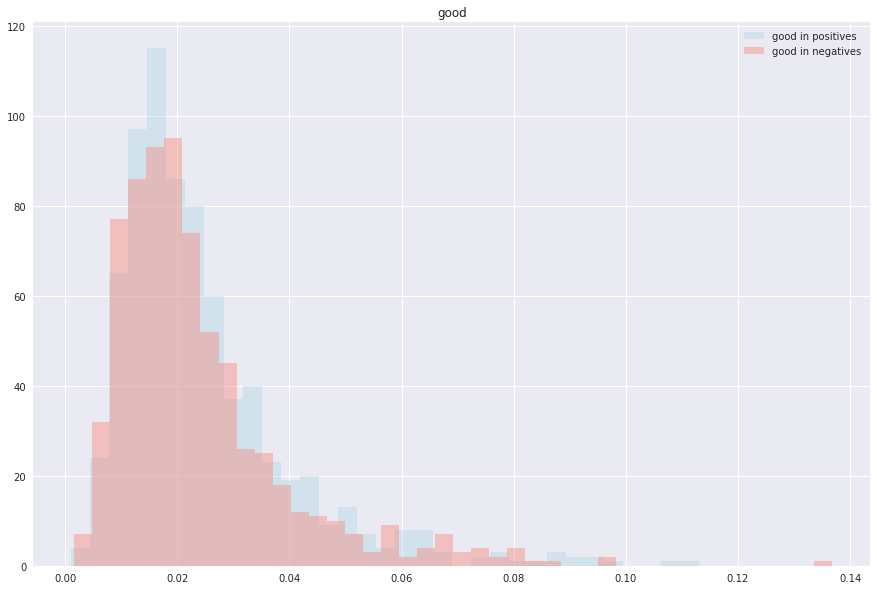

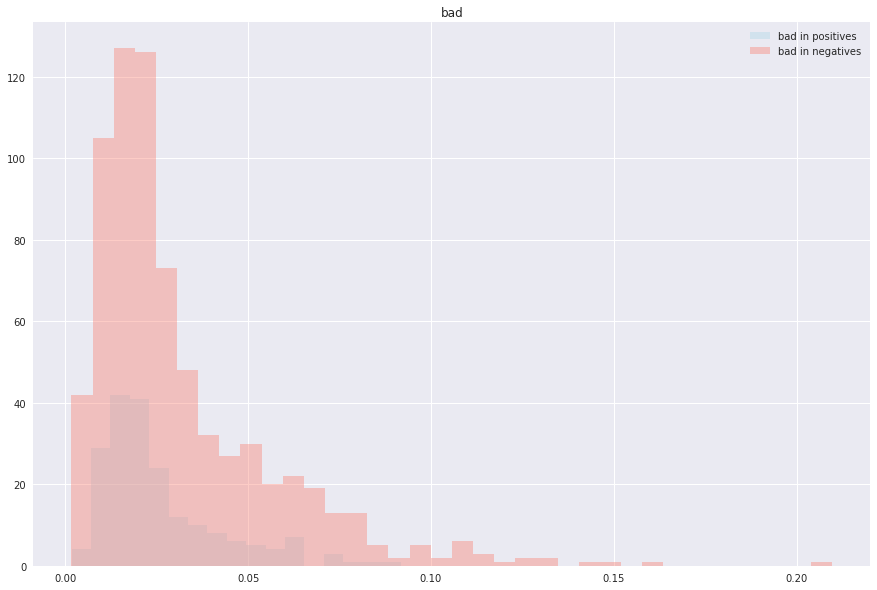

In [42]:
def draw_hist(pos, neg, word):
    plt.figure(figsize=(15,10))
    sns.distplot(pos, kde=False, color='lightblue',  label='{} in positives'.format(word))
    sns.distplot(neg, kde=False,  color='salmon',   label='{} in negatives'.format(word))
    plt.title(word)
    plt.legend(loc='upper right')
    plt.show()
    
draw_hist(good_true, good_false, 'good')
draw_hist(bad_true, bad_false, 'bad')



In [43]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True)

trues = 0
alls = 0

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    tflog_dir = 'tf_logs'
    summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())
    
    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_batch) in enumerate(batches_split):

        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        preds = s.run(model.prediction, feed_dict=fd)
        
        corrects = (labels_batch == preds).sum()
        
        trues += corrects
        alls += len(labels_batch)
        
        print('batch {} accuracy is {:.4f}'.format(i, trues / alls))
        
        if i == 100:
            break

Reading model parameters from checkpoints/checkpoint-240
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-240
batch 0 accuracy is 0.7000
batch 1 accuracy is 0.6000
batch 2 accuracy is 0.6667
batch 3 accuracy is 0.7000
batch 4 accuracy is 0.7000
batch 5 accuracy is 0.7000
batch 6 accuracy is 0.7143
batch 7 accuracy is 0.7125
batch 8 accuracy is 0.7000
batch 9 accuracy is 0.7300
batch 10 accuracy is 0.7455
batch 11 accuracy is 0.7417
batch 12 accuracy is 0.7385
batch 13 accuracy is 0.7357
batch 14 accuracy is 0.7267
batch 15 accuracy is 0.7312
batch 16 accuracy is 0.7353
batch 17 accuracy is 0.7278
batch 18 accuracy is 0.7211
batch 19 accuracy is 0.7250
batch 20 accuracy is 0.7286
batch 21 accuracy is 0.7318
batch 22 accuracy is 0.7304
batch 23 accuracy is 0.7250
batch 24 accuracy is 0.7320
batch 25 accuracy is 0.7269
batch 26 accuracy is 0.7296
batch 27 accuracy is 0.7214
batch 28 accuracy is 0.7310
batch 29 accuracy is 0.7300
batch 30 accuracy is 0.7323
batch 31 accurac

In [44]:
print(1.*trues/alls)

0.751485148515
